In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from utils import visualize_utils


In [2]:
log_root = "../unet/log/attribution_pickle/resUnet"
figure_log_root = "../unet/log/figures/resUnet"


window = [16, 13]
file_path = f"2019-09-29_berlin_9ch142-saliency-target-channel0-W{window[0]}-{window[1]}.npy"
window_size = 21
attr = np.load(os.path.join(log_root, file_path))
print(attr.shape)
file_format = "png"


(1, 115, 512, 448)


## Aggregate by channel: Which channel contributes a lot in predicting the selected pixel of channel 0 (first time slot, volume of NE)


In [3]:
agg_channel = np.sum(attr[0].reshape(attr[0].shape[0], -1), axis=1)
# Incident level per time epoch
agg_incident = agg_channel[:108].reshape(12, -1)[:, -1]
# Volume / speed per time epoch
agg_volume_speed = np.sum(agg_channel[:108].reshape(12, -1)[:, :-1].reshape(12, -1, 2), axis=1)/4
# Static features
agg_static = agg_channel[108:]

In [28]:
# Save as npy array
save_arr = np.concatenate((agg_volume_speed, agg_incident[:,None]), axis=1)
np.save("test.npy", save_arr)
# Save static features
np.save("static.npy", agg_static)

In [26]:
agg_incident[:,None].shape

(12, 1)

In [17]:
agg_volume_speed

array([[ 31.43058 ,  39.986336],
       [ 29.270575,  41.671303],
       [ 30.202805,  42.03207 ],
       [ 31.092756,  43.86717 ],
       [ 32.365734,  45.18937 ],
       [ 35.126225,  45.020878],
       [ 37.38875 ,  46.050217],
       [ 40.845757,  46.716114],
       [ 45.198544,  47.17302 ],
       [ 54.43602 ,  49.263836],
       [ 79.10679 ,  59.065666],
       [443.2268  , 283.50507 ]], dtype=float32)

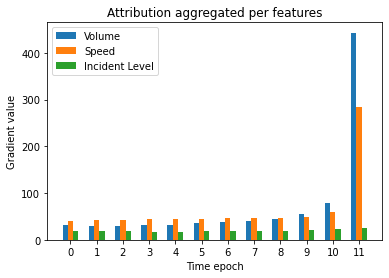

In [11]:
BAR_WIDTH = 0.2
x = np.arange(agg_incident.shape[0])
plt.bar(x-BAR_WIDTH, height=agg_volume_speed[:,0], label="Volume", width=BAR_WIDTH)
plt.bar(x, height=agg_volume_speed[:,1], label="Speed", width=BAR_WIDTH)
plt.bar(x+BAR_WIDTH, height=agg_incident, label="Incident Level", width=BAR_WIDTH)
plt.ylabel("Gradient value")
plt.xlabel("Time epoch")
plt.xticks(x)
plt.title("Attribution aggregated per features")
plt.legend()
plt.savefig(os.path.join(figure_log_root, os.path.split(file_path)[-1][:-3] + f"-attr-features.{file_format}"),
            bbox_inches="tight")
plt.show()

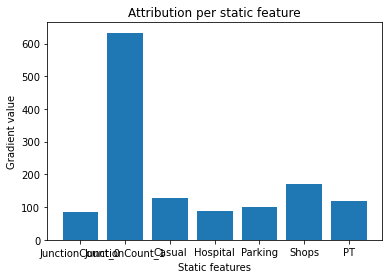

In [12]:
plt.bar(x=[v for k, v in sorted(visualize_utils.input_static_semantic_dict.items(), key=lambda _:_[0])], height=agg_static)
plt.ylabel("Gradient value")
plt.xlabel("Static features")
plt.savefig(os.path.join(figure_log_root, os.path.split(file_path)[-1][:-3] + f"-attr-static.{file_format}"),
            bbox_inches="tight")
plt.title("Attribution per static feature")
plt.show()

## Spatial attribution

### Road mask

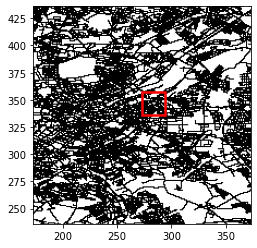

In [4]:
import matplotlib.patches as patches
import pickle

ROAD_MASK = True
if ROAD_MASK:
    # Road Mask
    MASK_PATH = r"C:\Users\jingyli\OwnDrive\IPA\python-eda-code\utils\Berlin.mask"
    road = pickle.load(open(MASK_PATH, "rb"))
    road_ = np.pad(road, pad_width=((8, 9), (6, 6)))
    # Visualize road network
    fig, axes = plt.subplots(1, 1,)
    axes.imshow(road, vmin=0, vmax=1, cmap="binary")
    rect = patches.Rectangle((window[1] * window_size, window[0] * window_size),
                             window_size, window_size,
                             linewidth=2.5, edgecolor="red", facecolor="none")
    axes.add_patch(rect)
    axes.set_xlim(window[1] * window_size - 100, window[1] * window_size + 100)
    axes.set_ylim(window[0] * window_size - 100, window[0] * window_size + 100)
    plt.savefig(os.path.join(figure_log_root,
                             f"road_network_center{window[0]}-{window[1]}.png"), bbox_inches="tight", pad_inches=0, dpi=150)


In [52]:
road_.shape

(512, 448)

### Attribution map

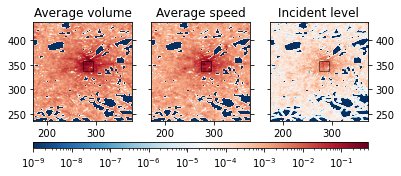

In [5]:
for i in range(11,12):
    start_epoch = i
    x = attr[0, start_epoch*9:(start_epoch+1)*9, :, :]
    if ROAD_MASK:
        x = np.where(road_[None, :, :], x, 10**(-10))
    fig, axes = plt.subplots(1, 3, sharey=True)
    visualize_utils.attr_one_time_epoch(fig, axes, x, max=0.5, min=10**(-9))
    for i in range(3):
        rect = patches.Rectangle((window[1]*window_size, window[0]*window_size),
                                 window_size, window_size,
                                 linewidth=0.5, edgecolor="black", facecolor="none")
        axes[i].add_patch(rect)
        axes[i].set_xlim(window[1]*window_size-100,window[1]*window_size+100)
        axes[i].set_ylim(window[0]*window_size-100,window[0]*window_size+100)
        filename = f"-attr-space-startt{start_epoch}.png" if not ROAD_MASK else f"-attr-space-road-startt{start_epoch}.png"
    plt.savefig(os.path.join(figure_log_root,
                             os.path.split(file_path)[-1][:-3]
                             +filename),
                bbox_inches="tight")

### Spatial attribution aggregation and save to npy

In [50]:
# Split attribution by time epoch and volume/speed/incident level
def spatial_attribution_agg(attr):
    '''
    An spatial attribution aggregate by time epoch and volume/speed/incident level
    return: np.array.shape = [12,3,512,448] 12 time epochs, 3 represents volume/speed/incident level at the time epoch
    '''
    attr_all = np.zeros((12,3,attr.shape[-2],attr.shape[-1]))
    for i in range(12):
        start_epoch = i
        # Non-static features per time epoch
        x = attr[0, start_epoch*9:(start_epoch+1)*9, :, :] 

        # Agg speed/volume per direction
        volume_idx = np.arange(0, 8, 2)
        speed_idx = np.arange(1, 8, 2)
        volume = np.mean(x[volume_idx, :, :], axis=0)[None,...]
        speed = np.mean(x[speed_idx, :, :], axis=0)[None,...]
        # Incident per time epoch
        incident = x[-1, :, :][None,...]
        # Attribution for this Time epoch
        attr_all[i] = np.concatenate((volume,speed,incident))[None,...]
    return attr_all

def spatial_attribution_agg_flat(attr):
    '''
    An spatial attribution aggregate by time epoch and volume/speed/incident level, and static features
    return: np.array.shape = [43,512,448]; last 7 in dim=0 are static features
    '''
    attr_ts = spatial_attribution_agg(attr)
    attr_ts = attr_ts.reshape(-1, attr_ts.shape[-2], attr_ts.shape[-1])
    static = attr[0, -7:, :, :]
    attr_all = np.concatenate((attr_ts,static))
    return attr_all


def zoom_to_range(window, window_size, zoom_window_num, arr):
    '''
        Zoom to a range
    '''
    # Zoom to the range
    start_x = (window[0]-zoom_window_num)*window_size
    end_x = (window[0]+zoom_window_num)*window_size
    start_y = (window[1]-zoom_window_num)*window_size
    end_y = (window[1]+zoom_window_num)*window_size
    start_x = start_x if start_x>0 else 0
    end_x = end_x if end_x<arr.shape[-2] else arr.shape[-2]
    start_y = start_y if start_x>0 else 0
    end_y = end_y if end_y<arr.shape[-1] else arr.shape[-1]
    return (start_x, end_x, start_y, end_y)

   

In [26]:
attr_all = spatial_attribution_agg_flat(attr)
attr_all.shape

(43, 512, 448)

In [61]:
zoom_window_num = 3
(start_x, end_x, start_y, end_y) = zoom_to_range(window, window_size, zoom_window_num, attr_all)
print(f"zoom to [{start_x}:{end_x}, {start_y}:{end_y}]")
attr_zoom = attr_all[:, 
                     start_x : end_x,
                     start_y : end_y]
attr_zoom.shape

zoom to [273:399, 210:336]


(43, 126, 126)

In [63]:
road_zoom = road_[start_x : end_x,
                     start_y : end_y]
road_zoom = road_zoom.astype(np.int8)
road_zoom.shape

(126, 126)

In [64]:
# Save attribution map
np.save("spatialattr-test.npy", attr_zoom)
np.save("road-test.npy", road_zoom)